In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from NoiseKD import Teacher

First hurdle. the embedding layer.  It requires the ints as inputs, not one hot.  i need one hot.  i will also need to rewire the LLM i use to do the same.  hmm.  save the weights, load it into a model that has the same shapes, but accepts one hot arrays, not vocab_indexes.

In [3]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, num_heads, hidden_dim, num_layers, dropout):
        super(TransformerEncoder, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embedding_dim, num_heads, hidden_dim, dropout),
            num_layers
        )

    def forward(self, x):
        return self.transformer(x)

class SimpleLanguageModel(nn.Module):
    def __init__(self, vocab_size, sequence_length, embedding_dim, class_num, num_heads, hidden_dim, num_layers, dropout):
        super(SimpleLanguageModel, self).__init__()

        # Define the embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Define the transformer encoder
        self.transformer_encoder = TransformerEncoder(embedding_dim, num_heads, hidden_dim, num_layers, dropout)
        
        self.fc1 = nn.Linear(sequence_length*embedding_dim, 1000)
        self.fc2 = nn.Linear(1000, 500)
        
        self.output_layer = nn.Linear(500, class_num)
        
        

    def forward(self, input_data):
        # Input_data is of shape (batch_size, sequence_length)
        # Apply embedding layer
        #print(input_data.shape)
        embedded = self.embedding(input_data)
        #print(embedded.shape)
        # Pass through the transformer encoder
        transformed = self.transformer_encoder(embedded)
        #print(transformed.shape) same as input duh: batch x sequence_length x embedding_dim
        flattened_tensor = transformed.view(-1,sequence_length*embedding_dim)
        f1 = nn.ReLU()(self.fc1(flattened_tensor))
        f2 = nn.ReLU()(self.fc2(f1))
        out = self.output_layer(f2)
        # Apply the output layer
        output = F.softmax(out,dim=1)

        return output
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [4]:
embedding_dim = 16
num_heads = 8
hidden_dim  = 11
num_layers = 2
dropout = 0.1
vocab_size = 80
class_num = 14
batch_size = 23
sequence_length = 160

In [5]:
SLM = SimpleLanguageModel(vocab_size, sequence_length, embedding_dim, class_num, num_heads, hidden_dim, num_layers, dropout)

In [6]:
SLM

SimpleLanguageModel(
  (embedding): Embedding(80, 16)
  (transformer_encoder): TransformerEncoder(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=11, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=11, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
       

In [7]:
input_data = torch.randint(low=0, high=vocab_size, size=(batch_size, sequence_length))
SLM(input_data)

tensor([[0.0688, 0.0667, 0.0741, 0.0779, 0.0660, 0.0802, 0.0652, 0.0688, 0.0800,
         0.0653, 0.0632, 0.0763, 0.0732, 0.0741],
        [0.0691, 0.0690, 0.0741, 0.0711, 0.0711, 0.0809, 0.0624, 0.0678, 0.0768,
         0.0660, 0.0765, 0.0697, 0.0690, 0.0764],
        [0.0759, 0.0805, 0.0741, 0.0721, 0.0611, 0.0771, 0.0616, 0.0676, 0.0725,
         0.0666, 0.0636, 0.0816, 0.0643, 0.0813],
        [0.0665, 0.0691, 0.0718, 0.0790, 0.0695, 0.0741, 0.0639, 0.0628, 0.0845,
         0.0666, 0.0709, 0.0723, 0.0790, 0.0702],
        [0.0774, 0.0607, 0.0723, 0.0716, 0.0680, 0.0749, 0.0660, 0.0702, 0.0808,
         0.0648, 0.0636, 0.0740, 0.0725, 0.0831],
        [0.0701, 0.0639, 0.0757, 0.0777, 0.0689, 0.0709, 0.0682, 0.0668, 0.0878,
         0.0660, 0.0669, 0.0725, 0.0668, 0.0778],
        [0.0643, 0.0649, 0.0725, 0.0727, 0.0724, 0.0676, 0.0673, 0.0702, 0.0841,
         0.0663, 0.0708, 0.0736, 0.0804, 0.0729],
        [0.0676, 0.0628, 0.0660, 0.0713, 0.0656, 0.0798, 0.0671, 0.0674, 0.0870,
  

In [8]:
count_parameters(SLM)

3072856

In [9]:
teacher_slm = Teacher(SLM,(sequence_length,)) #don't specify batch!!

In [22]:
teacher_slm.configure(dist_type = "ints"
                      , gen_m = vocab_size
                      , gen_n = 10_000
                      , gen_epochs = 10
                      , gen_lr = 0.01
                      , random_shuffle = 0.3
                      , out_type = "one-hot" ) #this is dying.  might be time for colab!!

Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)
lets try ints!


Configuring Teacher:: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.50s/it]

Teacher Configured


In [23]:
#this has a batch dim, but it isn't being ran in batches.  i think i need to do an append to self.inputs etc
args = { 'val_train' : "train"
                      , 'n' : 10_000
                      , 'dist_type' : 'ints'
                      , 'm' : vocab_size
                      , 'std': 1.0
        }
teacher_slm.generate_data(**args)

Configuring Teacher:: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 40.87it/s]


In [24]:
teacher_slm.model(teacher_slm.train_inputs[:10]).shape

torch.Size([10, 14])

In [25]:
teacher_slm.out_temp

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [26]:
teacher_slm.train_inputs.shape

torch.Size([10000, 160])

In [27]:
teacher_slm.model.embedding.weight.detach().numpy() #use this to make the matrix, just linear? not sure.

array([[ 0.3016965 , -0.24368332,  1.584515  , ...,  0.45116335,
         0.93156385, -0.5811422 ],
       [ 1.1358676 , -0.9271309 ,  0.583345  , ...,  0.3191328 ,
        -0.21009451, -2.265513  ],
       [-0.25016376, -1.467522  , -0.8725965 , ..., -1.678036  ,
         0.40563488, -0.15089063],
       ...,
       [-2.306779  , -0.18684156, -1.6040553 , ..., -0.43918175,
         0.856878  ,  0.20695004],
       [-0.4793628 ,  2.0016167 ,  0.10623812, ..., -1.420123  ,
        -0.2950828 , -1.0309    ],
       [ 0.5861007 , -1.0652558 ,  0.6993386 , ..., -0.9170168 ,
         1.7089394 ,  0.6240984 ]], dtype=float32)

In [28]:
test = torch.argmax(teacher_slm.train_targets,axis = -1) #the code is write, i just need this to be a better dist.

In [29]:
teacher_slm.train_targets[:10]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

In [30]:
teacher_slm.out_temp

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

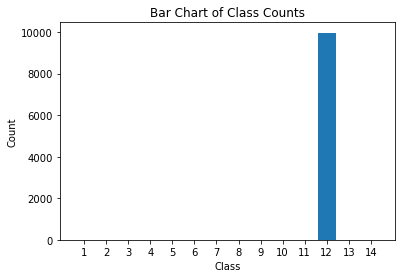

In [31]:
import numpy as np
import matplotlib.pyplot as plt
class_counts = [np.count_nonzero(test == i) for i in range(1, class_num + 1)]

# Create a bar chart
plt.bar(range(1, class_num + 1), class_counts, align='center')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Bar Chart of Class Counts')
plt.xticks(range(1, class_num + 1))
plt.show()

specify gen outputs.  we need one hots
i can do this better than chat gpt lol

In [20]:
##this function works, it is in LABNET.  
def one_hot_last_dim(tensor_shape):
    num_classes = tensor_shape[-1]
    random_idx = np.random.randint(1, num_classes + 1, size=tensor_shape[:-1])
    zero_tensor = np.zeros(tensor_shape, dtype=int)
    last_dim_indices = np.arange(num_classes)
    zero_tensor[..., :, last_dim_indices] = (random_idx[..., np.newaxis] == last_dim_indices)
    return zero_tensor

In [21]:
x

NameError: name 'x' is not defined

In [ ]:
axis_to_shuffle = 0

# Shuffle the tensor along the specified axis
shuffled_tensor = np.take(x, np.random.permutation(x.shape[0]), axis=0)

print(shuffled_tensor)


In [ ]:
import random


for i in range(10):
    random_number = random.random()
    print(random_number)